In [39]:
import pandas as pd
import numpy as np
import re

def clean_log_dataset(file_path):
    """
    Cleans a messy log dataset from Excel format.
    Handles NaNs, unknowns, duplicates, blank spaces, wrong values, repeated logs, etc.
    """

    # Load Excel file
    df = pd.read_excel(file_path)

    # Drop empty rows and columns
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    # Standardize column names
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

    # Replace common invalid values with NaN
    invalid_values = ["", "NaN", "nan", "null", "unknown", "none", "-", "--", "n/a", "无"]
    df.replace(invalid_values, np.nan, inplace=True)

    # Drop duplicates
    df.drop_duplicates(inplace=True)

    # Fill missing values using forward fill and then backward fill as backup
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Remove special characters and normalize strings
    def clean_string(val):
        if isinstance(val, str):
            val = val.strip().lower()
            val = re.sub(r"[\"']", "", val)  # remove quotes
            val = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5\s+]", "", val)  # keep Chinese, alphanumeric, space
            return val
        return val

    df = df.applymap(clean_string)

    # Remove entries with missing required fields if still any
    required_fields = ['timestamp', 'type', 'content']
    df.dropna(subset=required_fields, inplace=True)

    # Optional: Convert timestamp if not in datetime format
    try:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    except Exception as e:
        print(f"Warning: Could not parse 'timestamp' column. Error: {e}")

    return df

# Example usage:
file_path = "./log_cleaning.xlsx"
clean_df = clean_log_dataset(file_path)
clean_df.head()


C:\Users\Asus\AppData\Local\Temp\ipykernel_17396\4139843110.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_17396\4139843110.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_17396\4139843110.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_string)


,timestamp,type,content
0,2025-07-18 09:52:00,filed,搜索
1,2025-07-18 09:52:00,button,搜索
3,2025-07-18 09:52:00,button,搜索
5,2025-07-18 09:52:00,button,检索
6,2025-07-18 09:52:00,button,rpa+ai在企业财务领域应用研究及实践


In [40]:
def assign_sessions(df, timestamp_col='timestamp', gap_minutes=10):
    """
    Automatically assigns session IDs based on time gaps between actions.
    If user column is not present, assumes single-user logs.
    """
    df = df.sort_values(by=timestamp_col).copy()

    # Calculate time difference between events
    df['time_diff'] = df[timestamp_col].diff().dt.total_seconds().div(60)

    # Define session boundaries
    df['new_session'] = (df['time_diff'] > gap_minutes) | (df['time_diff'].isna())

    # Assign session IDs
    df['session_id'] = 'S_' + df['new_session'].cumsum().astype(int).astype(str)

    # Drop helper columns
    df.drop(columns=['time_diff', 'new_session'], inplace=True)

    return df


In [41]:
clean_df = assign_sessions(clean_df, timestamp_col='timestamp')


In [42]:
clean_df.rename(columns={'action': 'semantic_label'}, inplace=True)
print(clean_df.columns.tolist())


['timestamp', 'type', 'content', 'session_id']


In [43]:
print(clean_df.columns.tolist())
clean_df.head(10)


['timestamp', 'type', 'content', 'session_id']


,timestamp,type,content,session_id
0,2025-07-18 09:52:00,filed,搜索,S_1
1,2025-07-18 09:52:00,button,搜索,S_1
3,2025-07-18 09:52:00,button,搜索,S_1
5,2025-07-18 09:52:00,button,检索,S_1
6,2025-07-18 09:52:00,button,rpa+ai在企业财务领域应用研究及实践,S_1
7,2025-07-18 09:52:00,button,pdf下载,S_1
8,2025-07-18 09:52:00,button,基因编辑水稻rpacrisprcas12b快速检测方法的建立,S_1
10,2025-07-18 09:52:00,button,热带水产品中溶藻弧菌重组酶聚合酶等温扩增快速检测方法的建立,S_1
12,2025-07-18 09:52:00,button,基于rpalfd可视化快速检测肺炎克雷伯菌方法的建立及评价,S_1
14,2025-07-18 09:52:00,button,基于crisprcas12a系统联合重组酶聚合酶扩增的鸭星状病毒2型核酸检测试纸条的制备,S_1


In [44]:
# Create a semantic_label column by combining 'type' and 'content'
clean_df['semantic_label'] = clean_df['type'].astype(str).str.lower().str.strip() + " → " + clean_df['content'].astype(str).str.lower().str.strip()
print(clean_df[['timestamp', 'session_id', 'semantic_label']].head(10))


             timestamp session_id  \
0  2025-07-18 09:52:00        S_1   
1  2025-07-18 09:52:00        S_1   
3  2025-07-18 09:52:00        S_1   
5  2025-07-18 09:52:00        S_1   
6  2025-07-18 09:52:00        S_1   
7  2025-07-18 09:52:00        S_1   
8  2025-07-18 09:52:00        S_1   
10 2025-07-18 09:52:00        S_1   
12 2025-07-18 09:52:00        S_1   
14 2025-07-18 09:52:00        S_1   

                                       semantic_label  
0                                          filed → 搜索  
1                                         button → 搜索  
3                                         button → 搜索  
5                                         button → 检索  
6                       button → rpa+ai在企业财务领域应用研究及实践  
7                                      button → pdf下载  
8             button → 基因编辑水稻rpacrisprcas12b快速检测方法的建立  
10             button → 热带水产品中溶藻弧菌重组酶聚合酶等温扩增快速检测方法的建立  
12             button → 基于rpalfd可视化快速检测肺炎克雷伯菌方法的建立及评价  
14  button → 基于crisprcas12a系统联合重

In [45]:
def group_logs_by_session(df, session_col='session_id', timestamp_col='timestamp'):
    df = df.sort_values(by=[session_col, timestamp_col])
    df['prev_action'] = df.groupby(session_col)['semantic_label'].shift()
    df = df[df['semantic_label'] != df['prev_action']].copy()
    df.drop(columns=['prev_action'], inplace=True)
    session_traces = df.groupby(session_col)['semantic_label'].apply(list).to_dict()
    return session_traces

# Apply the function
session_logs = group_logs_by_session(clean_df)

# Preview 5 session traces
for sid, trace in list(session_logs.items())[:5]:
    print(f"{sid}: {trace}")


S_1: ['filed → 搜索', 'button → 搜索', 'button → 检索', 'button → rpa+ai在企业财务领域应用研究及实践', 'button → pdf下载', 'button → 基因编辑水稻rpacrisprcas12b快速检测方法的建立', 'button → 热带水产品中溶藻弧菌重组酶聚合酶等温扩增快速检测方法的建立', 'button → 基于rpalfd可视化快速检测肺炎克雷伯菌方法的建立及评价', 'button → 基于crisprcas12a系统联合重组酶聚合酶扩增的鸭星状病毒2型核酸检测试纸条的制备', 'button → crisprcas检测系统在食品供应链中安全防控的应用研究进展']


C:\Users\Asus\AppData\Local\Temp\ipykernel_19080\1020391375.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_19080\1020391375.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)


✅ Cleaned Data Preview:
                  timestamp    type                             content  \
7 2025-07-18 09:52:00+00:00  button                             "pdf下载"   
6 2025-07-18 09:52:00+00:00  button              "rpa+ai在企业财务领域应用研究及实践"   
8 2025-07-18 09:52:00+00:00  button  "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"   
3 2025-07-18 09:52:00+00:00  button                                "搜索"   
5 2025-07-18 09:52:00+00:00  button                                "检索"   

  session_id                               semantic_label case:concept:name  \
7        0.0                             button → "pdf下载"               0.0   
6        1.0              button → "rpa+ai在企业财务领域应用研究及实践"               1.0   
8        2.0  button → "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"               2.0   
3        3.0                                button → "搜索"               3.0   
5        4.0                                button → "检索"               4.0   

                                  concept:name    

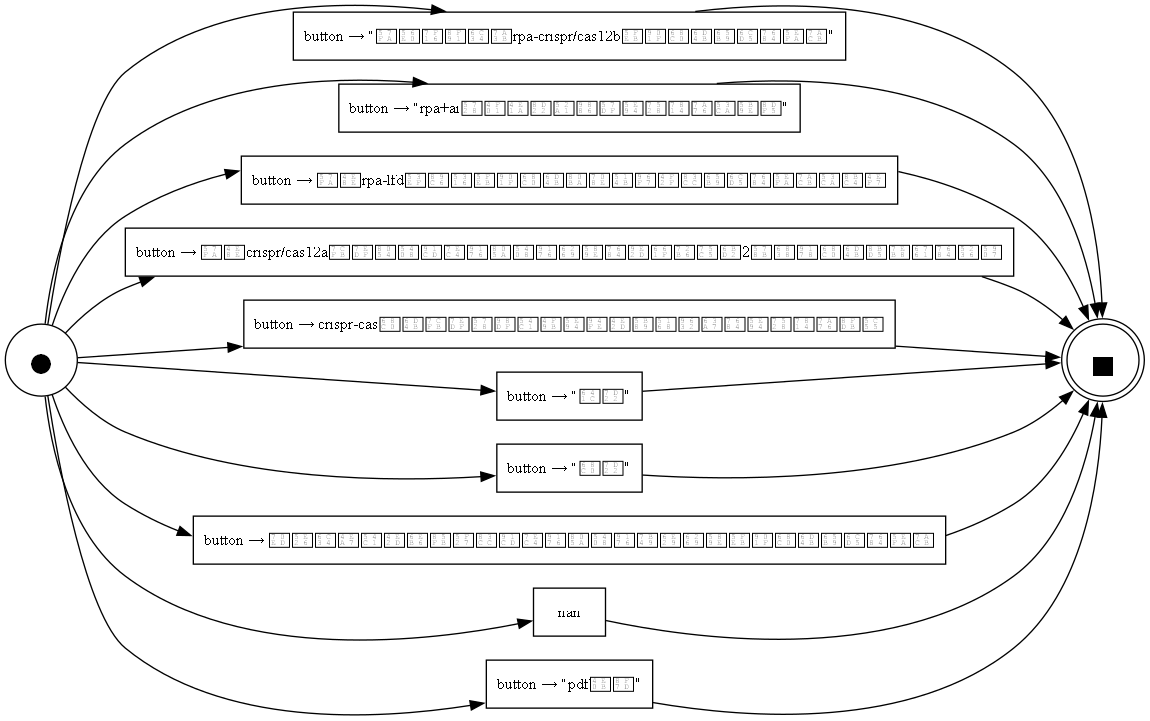

✅ Process model generated and visualized successfully.


In [11]:
import pandas as pd
import numpy as np
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

def log_to_eventlog_machine(filepath, file_type='excel'):
    """
    Full automated machine to process messy log data and generate PM4Py EventLog.
    Steps:
        - Load and clean log file
        - Standardize structure
        - Assign session_id and semantic_label
        - Remove redundant actions
        - Convert to PM4Py EventLog format
    Returns:
        - Cleaned DataFrame
        - EventLog object
    """

    # 1. Load log file
    if file_type == 'excel':
        df = pd.read_excel(filepath)
    elif file_type == 'csv':
        df = pd.read_csv(filepath)
    else:
        raise ValueError("Unsupported file_type. Use 'excel' or 'csv'.")

    # 2. Drop empty rows/columns
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    # 3. Standardize column names
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

    # 4. Replace common invalid values
    invalid_values = ["", "NaN", "nan", "null", "unknown", np.nan]
    df.replace(invalid_values, np.nan, inplace=True)

    # 5. Drop duplicates and fill missing values
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)

    # 6. Clean string formatting
    df = df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

    # 7. Assign session_id if missing
    if 'session_id' not in df.columns:
        df['session_id'] = df.groupby(['type', 'content']).ngroup().astype(str)

    # 8. Create semantic_label if missing
    if 'semantic_label' not in df.columns:
        df['semantic_label'] = df['type'] + " → " + df['content']

    # 9. Remove repeated consecutive actions
    df = df.sort_values(by=['session_id', 'timestamp'])
    df['prev_action'] = df.groupby('session_id')['semantic_label'].shift()
    df = df[df['semantic_label'] != df['prev_action']].copy()
    df.drop(columns=['prev_action'], inplace=True)

    # 10. Prepare for EventLog conversion
    df['case:concept:name'] = df['session_id']
    df['concept:name'] = df['semantic_label']
    df['time:timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.dropna(subset=['time:timestamp'], inplace=True)

    df_pm4py = dataframe_utils.convert_timestamp_columns_in_df(df)
    event_log = log_converter.apply(df_pm4py, variant=log_converter.Variants.TO_EVENT_LOG)

    return df, event_log

# === Step 1: Run the machine to load, clean, and convert to event log ===
file_path = "./log_cleaning.xlsx"  # Replace with your actual Excel file path
clean_df, event_log = log_to_eventlog_machine(file_path, file_type='excel')

# === Step 2: Preview cleaned data (optional) ===
print("✅ Cleaned Data Preview:")
print(clean_df.head())

# === Step 3: Preview first 2 event traces (optional) ===
print("\n✅ Event Log Sample:")
for trace in event_log[:2]:
    for event in trace:
        print(event)
    print("----")

# === Step 4: Discover and visualize process model (Petri Net) ===
print("\n⏳ Generating Process Model...")
net, initial_marking, final_marking = alpha_miner.apply(event_log)

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)
print("✅ Process model generated and visualized successfully.")


**# **SECOND VERSION WITH INDUCTIVE MINER ALGORITHM****

                  timestamp    type                             content  \
7 2025-07-18 09:52:00+00:00  button                             "pdf下载"   
6 2025-07-18 09:52:00+00:00  button              "rpa+ai在企业财务领域应用研究及实践"   
8 2025-07-18 09:52:00+00:00  button  "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"   
1 2025-07-18 09:52:00+00:00  button                                "搜索"   
5 2025-07-18 09:52:00+00:00  button                                "检索"   

  session_id                               semantic_label case:concept:name  \
7          0                             button → "pdf下载"                 0   
6          1              button → "rpa+ai在企业财务领域应用研究及实践"                 1   
8          2  button → "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"                 2   
1          3                                button → "搜索"                 3   
5          4                                button → "检索"                 4   

                                  concept:name            time:timestamp  

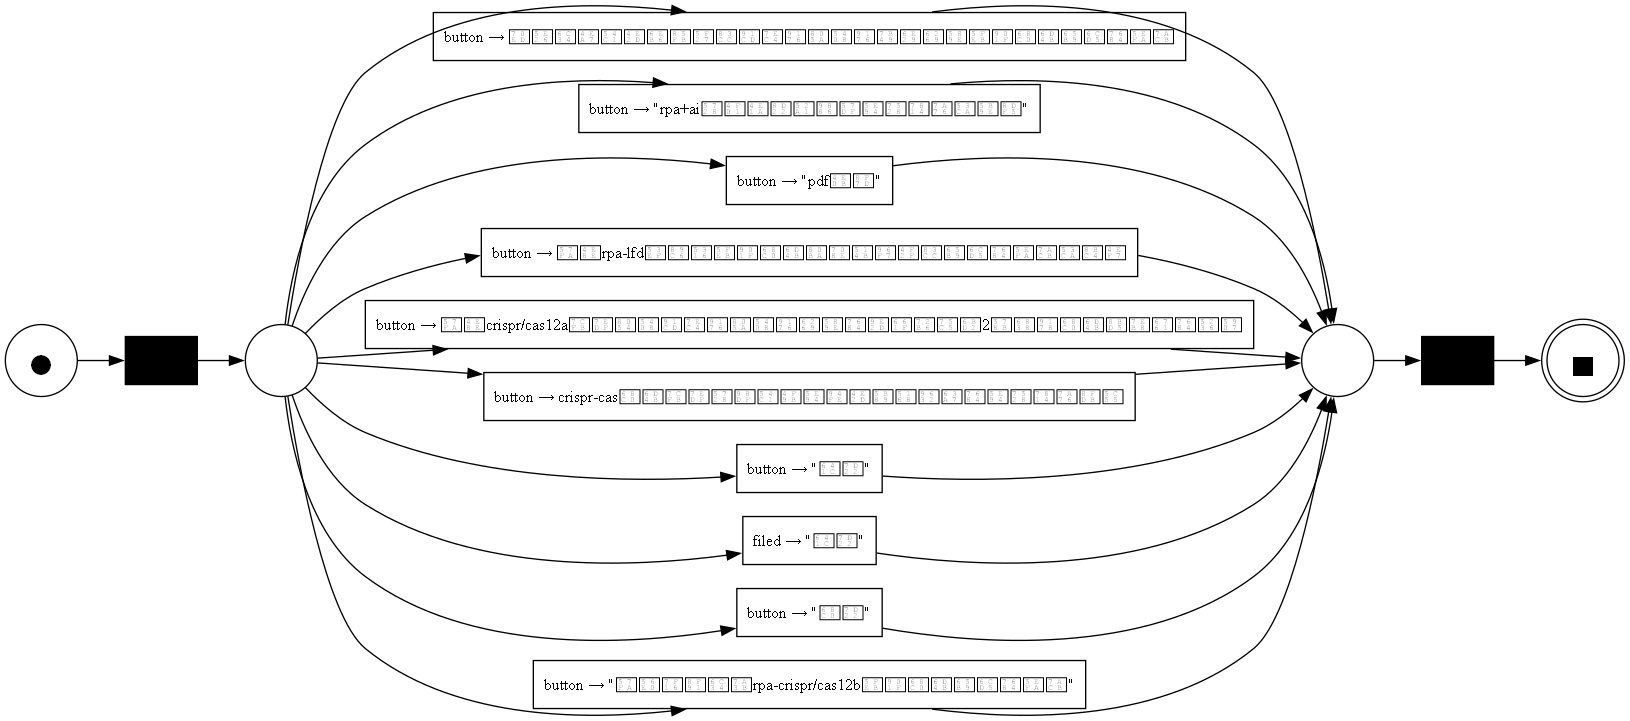

✅ Inductive Miner: Petri net generated successfully.


(places: [ p_3, p_4, sink, source ]
 transitions: [ (10175043-0eb7-4a78-9e9d-16221660aa39, 'button → "rpa+ai在企业财务领域应用研究及实践"'), (27607886-7a83-4348-861d-b100ec133189, 'button → "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"'), (27e75a54-8cb4-4b54-9312-dcc7f80e4cf0, 'button → crispr-cas检测系统在食品供应链中安全防控的应用研究进展'), (2d2252b6-84f1-44eb-8176-da92bdc9ae14, 'button → "pdf下载"'), (3e4d7f45-aa8f-4759-b3a5-483a795410f6, 'button → "搜索"'), (b0c5ccae-264c-4a97-b5f0-075b7a6a615a, 'button → 基于crispr/cas12a系统联合重组酶聚合酶扩增的鸭星状病毒2型核酸检测试纸条的制备'), (b5ea64f0-453d-4f32-a087-5126f7785eb7, 'button → 热带水产品中溶藻弧菌重组酶聚合酶等温扩增快速检测方法的建立'), (b5f46743-a987-4712-9122-dd2fe5c3da87, 'button → 基于rpa-lfd可视化快速检测肺炎克雷伯菌方法的建立及评价'), (ecaebf37-5e7b-4b41-9515-5bf84c8f3667, 'filed → "搜索"'), (ffa7e781-3643-4339-b734-3ecaeede8b9c, 'button → "检索"'), (tau_1, None), (tau_2, None) ]
 arcs: [ (10175043-0eb7-4a78-9e9d-16221660aa39, 'button → "rpa+ai在企业财务领域应用研究及实践"')->p_4, (27607886-7a83-4348-861d-b100ec133189, 'button → "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"')->p

In [16]:
import pandas as pd
import numpy as np
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter


def log_to_eventlog_machine(filepath, file_type='excel'):
    """
    Complete automated machine to process messy log data into PM4Py-compatible EventLog.
    """

    # 1. Load file
    if file_type == 'excel':
        df = pd.read_excel(filepath)
    elif file_type == 'csv':
        df = pd.read_csv(filepath)
    else:
        raise ValueError("Unsupported file_type")

    # 2. Drop empty rows/columns
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    # 3. Standardize column names
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

    # 4. Replace invalid values
    invalid_values = ["", "NaN", "nan", "null", "unknown", np.nan]
    df.replace(invalid_values, np.nan, inplace=True)

    # 5. Drop duplicates and fill missing
    df.drop_duplicates(inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # 6. Clean string formatting
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

    # 7. Add session_id if missing
    if 'session_id' not in df.columns:
        df['session_id'] = df.groupby(['type', 'content']).ngroup().astype(str)

    # 8. Add semantic_label if missing
    if 'semantic_label' not in df.columns:
        df['semantic_label'] = df['type'].astype(str) + " → " + df['content'].astype(str)

    # 9. Remove repeated actions
    df = df.sort_values(by=['session_id', 'timestamp'])
    df['prev_action'] = df.groupby('session_id')['semantic_label'].shift()
    df = df[df['semantic_label'] != df['prev_action']].copy()
    df.drop(columns=['prev_action'], inplace=True)

    # 10. Generate PM4Py EventLog
    df['case:concept:name'] = df['session_id'].astype(str)
    df['concept:name'] = df['semantic_label'].astype(str)
    df['time:timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.dropna(subset=['time:timestamp'], inplace=True)

    df_pm4py = dataframe_utils.convert_timestamp_columns_in_df(df)
    event_log = log_converter.apply(df_pm4py, variant=log_converter.Variants.TO_EVENT_LOG)

    return df, event_log

def discover_and_visualize_process_model(event_log):
    """
    Discover and visualize a process model using Inductive Miner.
    Converts the ProcessTree to a Petri net if needed.
    """
    try:
        # Step 1: Discover the process tree
        process_tree = inductive_miner.apply(event_log)

        # Step 2: Convert ProcessTree to Petri net
        net, initial_marking, final_marking = pt_converter.apply(process_tree)

        # Step 3: Visualize Petri net
        gviz = pn_visualizer.apply(net, initial_marking, final_marking)
        pn_visualizer.view(gviz)

        print("✅ Inductive Miner: Petri net generated successfully.")
        return net, initial_marking, final_marking

    except Exception as e:
        print(f"❌ Failed to generate process model: {e}")
        return None, None, None

# === Step 1: Run the machine
file_path = "./log_cleaning.xlsx"
clean_df, event_log = log_to_eventlog_machine(file_path, file_type='excel')

# === Step 2: Optional preview
print(clean_df.head())

# === Step 3: Optional preview of event log
for trace in event_log[:2]:
    for event in trace:
        print(event)
    print("----")

# === Step 4: Discover and visualize the model
discover_and_visualize_process_model(event_log)


**# **THIRD VERSION WITH INDUCTIVE HEURISTICS ALGORITHM****

In [20]:
import pandas as pd
import numpy as np
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from IPython.display import Image, display

def log_to_eventlog_machine(filepath, file_type='excel'):
    """
    Complete automated machine to process messy log data into PM4Py-compatible EventLog.
    """
    # 1. Load file
    if file_type == 'excel':
        df = pd.read_excel(filepath)
    elif file_type == 'csv':
        df = pd.read_csv(filepath)
    else:
        raise ValueError("Unsupported file_type")

    # 2. Drop empty rows/columns
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    # 3. Standardize column names
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

    # 4. Replace invalid values
    invalid_values = ["", "NaN", "nan", "null", "unknown", np.nan]
    df.replace(invalid_values, np.nan, inplace=True)

    # 5. Drop duplicates and fill missing
    df.drop_duplicates(inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # 6. Clean string formatting
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

    # 7. Add session_id if missing
    if 'session_id' not in df.columns:
        df['session_id'] = df.groupby(['type', 'content']).ngroup().astype(str)

    # 8. Add semantic_label if missing
    if 'semantic_label' not in df.columns:
        df['semantic_label'] = df['type'].astype(str) + " → " + df['content'].astype(str)

    # 9. Remove repeated actions
    df = df.sort_values(by=['session_id', 'timestamp'])
    df['prev_action'] = df.groupby('session_id')['semantic_label'].shift()
    df = df[df['semantic_label'] != df['prev_action']].copy()
    df.drop(columns=['prev_action'], inplace=True)

    # 10. Generate PM4Py EventLog
    df['case:concept:name'] = df['session_id'].astype(str)
    df['concept:name'] = df['semantic_label'].astype(str)
    df['time:timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.dropna(subset=['time:timestamp'], inplace=True)

    df_pm4py = dataframe_utils.convert_timestamp_columns_in_df(df)
    event_log = log_converter.apply(df_pm4py, variant=log_converter.Variants.TO_EVENT_LOG)

    return df, event_log


def discover_and_visualize_heuristics_model(event_log):
    """
    Discover and visualize a process model using Heuristics Miner.
    """
    try:
        heu_net = heuristics_miner.apply_heu(event_log)
        gviz = hn_visualizer.apply(heu_net)
        hn_visualizer.save(gviz, "heuristics_model.png")
        display(Image(filename="heuristics_model.png"))

        print("✅ Heuristics Miner: Heuristic net generated successfully.")
        return heu_net
    except Exception as e:
        print(f"❌ Failed to generate heuristics model: {e}")
        return None


# === Step 1: Run the machine
file_path = "./log_cleaning.xlsx"  # Replace with your actual Excel file
clean_df, event_log = log_to_eventlog_machine(file_path, file_type='excel')

# === Step 2: Preview
print(clean_df.head())

# === Step 3: Optional: Check first 2 traces
for trace in event_log[:2]:
    for event in trace:
        print(event)
    print("----")

# === Step 4: Discover and visualize model using Heuristics Miner
discover_and_visualize_heuristics_model(event_log)


                  timestamp    type                             content  \
7 2025-07-18 09:52:00+00:00  button                             "pdf下载"   
6 2025-07-18 09:52:00+00:00  button              "rpa+ai在企业财务领域应用研究及实践"   
8 2025-07-18 09:52:00+00:00  button  "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"   
1 2025-07-18 09:52:00+00:00  button                                "搜索"   
5 2025-07-18 09:52:00+00:00  button                                "检索"   

  session_id                               semantic_label case:concept:name  \
7          0                             button → "pdf下载"                 0   
6          1              button → "rpa+ai在企业财务领域应用研究及实践"                 1   
8          2  button → "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"                 2   
1          3                                button → "搜索"                 3   
5          4                                button → "检索"                 4   

                                  concept:name            time:timestamp  

✅ Heuristics Miner: Heuristic net generated successfully.


{'button → "pdf下载"': (node:button → "pdf下载" connections:{}), 'button → "rpa+ai在企业财务领域应用研究及实践"': (node:button → "rpa+ai在企业财务领域应用研究及实践" connections:{}), 'button → "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"': (node:button → "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立" connections:{}), 'button → "搜索"': (node:button → "搜索" connections:{}), 'button → "检索"': (node:button → "检索" connections:{}), 'button → crispr-cas检测系统在食品供应链中安全防控的应用研究进展': (node:button → crispr-cas检测系统在食品供应链中安全防控的应用研究进展 connections:{}), 'button → 基于crispr/cas12a系统联合重组酶聚合酶扩增的鸭星状病毒2型核酸检测试纸条的制备': (node:button → 基于crispr/cas12a系统联合重组酶聚合酶扩增的鸭星状病毒2型核酸检测试纸条的制备 connections:{}), 'button → 基于rpa-lfd可视化快速检测肺炎克雷伯菌方法的建立及评价': (node:button → 基于rpa-lfd可视化快速检测肺炎克雷伯菌方法的建立及评价 connections:{}), 'button → 热带水产品中溶藻弧菌重组酶聚合酶等温扩增快速检测方法的建立': (node:button → 热带水产品中溶藻弧菌重组酶聚合酶等温扩增快速检测方法的建立 connections:{}), 'filed → "搜索"': (node:filed → "搜索" connections:{})}

****COMBINED ALGORITHM****

ℹ️ Dataset is small (10 traces). Using Alpha Miner.


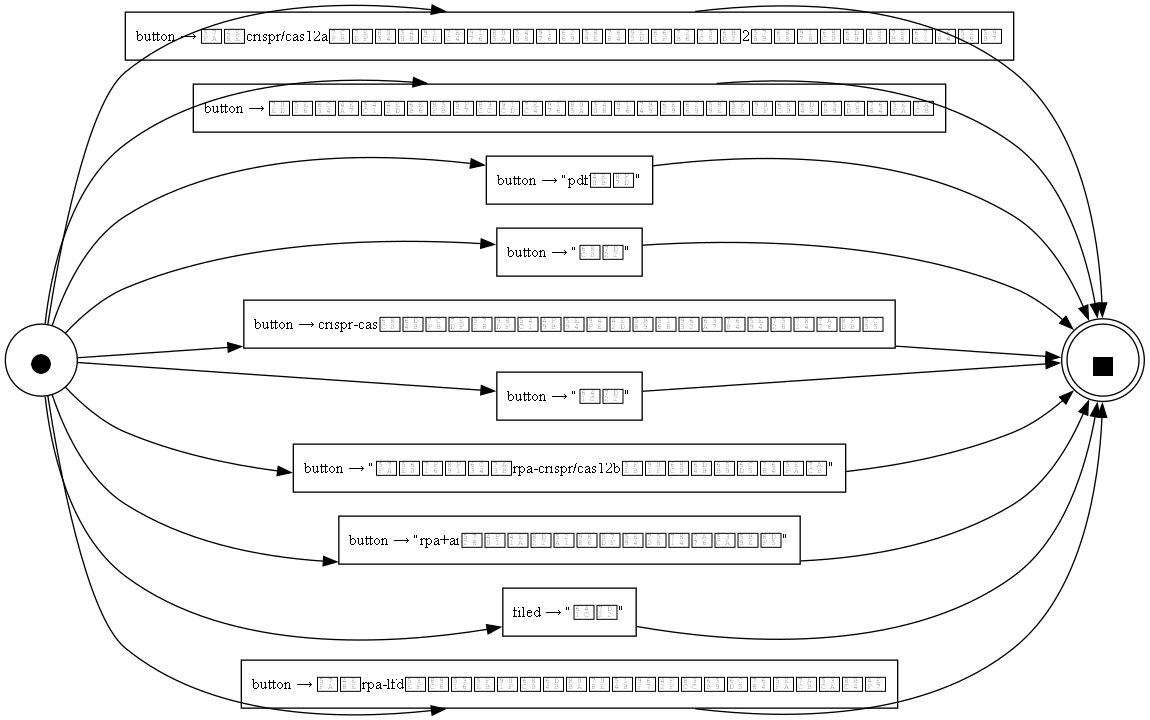

In [25]:
import pandas as pd
import numpy as np
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.obj import EventLog
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter

def smart_process_miner(filepath, file_type='excel'):
    """
    Smart process model generator that selects the discovery algorithm based on dataset size.
    """

    # Step 1: Load & Clean Data
    if file_type == 'excel':
        df = pd.read_excel(filepath)
    elif file_type == 'csv':
        df = pd.read_csv(filepath)
    else:
        raise ValueError("Unsupported file_type")

    # Clean
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    invalid_values = ["", "NaN", "nan", "null", "unknown", np.nan]
    df.replace(invalid_values, np.nan, inplace=True)
    df.drop_duplicates(inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

    # Session ID and semantic label
    if 'session_id' not in df.columns:
        df['session_id'] = df.groupby(['type', 'content']).ngroup().astype(str)
    if 'semantic_label' not in df.columns:
        df['semantic_label'] = df['type'].astype(str) + " → " + df['content'].astype(str)

    df = df.sort_values(by=['session_id', 'timestamp'])
    df['prev_action'] = df.groupby('session_id')['semantic_label'].shift()
    df = df[df['semantic_label'] != df['prev_action']].copy()
    df.drop(columns=['prev_action'], inplace=True)

    df['case:concept:name'] = df['session_id']
    df['concept:name'] = df['semantic_label']
    df['time:timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.dropna(subset=['time:timestamp'], inplace=True)

    df_pm4py = dataframe_utils.convert_timestamp_columns_in_df(df)
    event_log = log_converter.apply(df_pm4py, variant=log_converter.Variants.TO_EVENT_LOG)

    # Step 2: Choose algorithm based on trace count
    trace_count = len(event_log)

    try:
        if trace_count <= 100:
            print(f"ℹ️ Dataset is small ({trace_count} traces). Using Alpha Miner.")
            net, im, fm = alpha_miner.apply(event_log)
            gviz = pn_visualizer.apply(net, im, fm, parameters={"format": "png", "fontsize": 14, "size": "15!"})
            pn_visualizer.view(gviz)
            return "Alpha Miner", net, im, fm

        elif 100 < trace_count <= 500:
            print(f"ℹ️ Medium dataset ({trace_count} traces). Using Inductive Miner.")
            process_tree = inductive_miner.apply(event_log)
            net, im, fm = pt_converter.apply(process_tree)
            gviz = pn_visualizer.apply(net, im, fm, parameters={"format": "png", "fontsize": 14, "size": "15!"})
            pn_visualizer.view(gviz)
            return "Inductive Miner", net, im, fm

        else:
            print(f"ℹ️ Large dataset ({trace_count} traces). Using Heuristics Miner.")
            heu_net = heuristics_miner.apply_heu(event_log)
            gviz = hn_visualizer.apply(heu_net, parameters={"format": "png", "fontsize": 14, "size": "15!"})
            hn_visualizer.view(gviz)
            return "Heuristics Miner", heu_net, None, None

    except Exception as e:
        print(f"❌ Failed to discover model: {e}")
        return None, None, None, None
file_path = "./log_cleaning.xlsx"
algo_used, net, im, fm = smart_process_miner(file_path, file_type='excel')


Number of rows after cleaning: 10
                   timestamp    type  \
7  2025-07-18 09:52:00+00:00  button   
6  2025-07-18 09:52:00+00:00  button   
8  2025-07-18 09:52:00+00:00  button   
1  2025-07-18 09:52:00+00:00  button   
5  2025-07-18 09:52:00+00:00  button   
16 2025-07-18 09:52:00+00:00  button   
14 2025-07-18 09:52:00+00:00  button   
12 2025-07-18 09:52:00+00:00  button   
10 2025-07-18 09:52:00+00:00  button   
0  2025-07-18 09:52:00+00:00   filed   

                                          content session_id  \
7                                         "pdf下载"          0   
6                          "rpa+ai在企业财务领域应用研究及实践"          1   
8              "基因编辑水稻rpa-crispr/cas12b快速检测方法的建立"          2   
1                                            "搜索"          3   
5                                            "检索"          4   
16               crispr-cas检测系统在食品供应链中安全防控的应用研究进展          5   
14  基于crispr/cas12a系统联合重组酶聚合酶扩增的鸭星状病毒2型核酸检测试纸条的制备          6   
12           

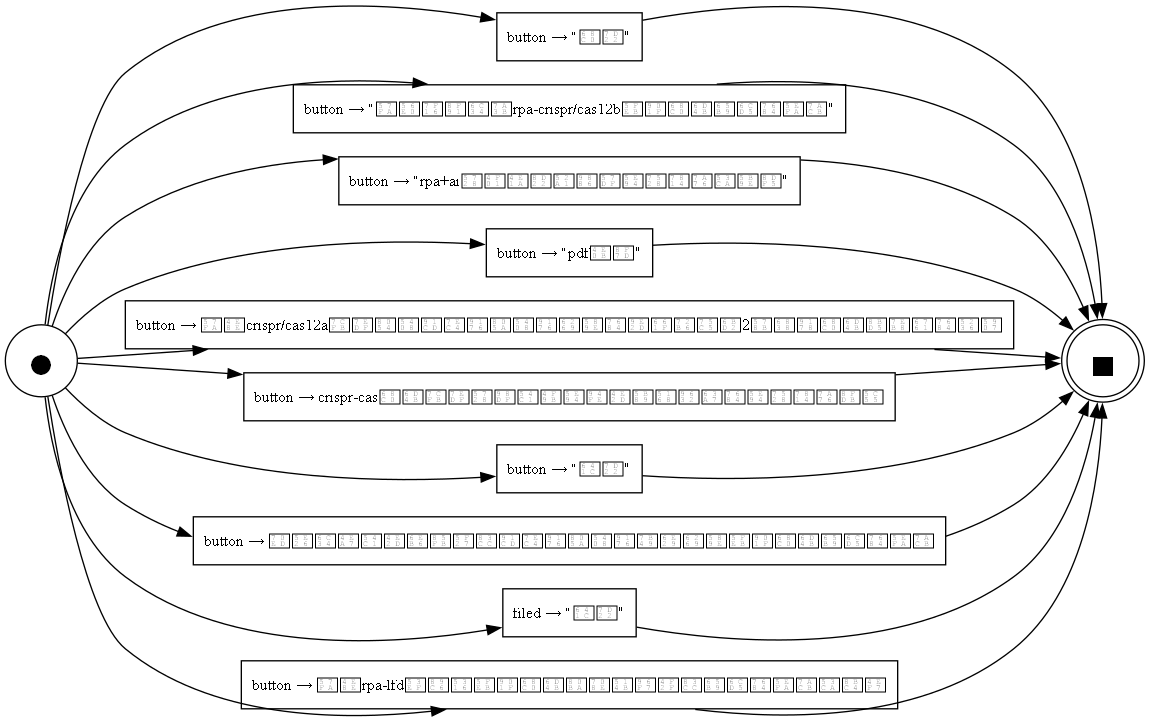

In [35]:
import pandas as pd
import numpy as np
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.obj import EventLog
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter

def smart_process_miner(filepath, file_type='excel'):
    """
    Smart process model generator that selects the discovery algorithm based on dataset size.
    """

    # Step 1: Load & Clean Data
    if file_type == 'excel':
        df = pd.read_excel(filepath)
    elif file_type == 'csv':
        df = pd.read_csv(filepath)
    else:
        raise ValueError("Unsupported file_type")

    # Clean
    df.dropna(how='all', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    invalid_values = ["", "NaN", "nan", "null", "unknown", np.nan]
    df.replace(invalid_values, np.nan, inplace=True)
    df.drop_duplicates(inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str).str.strip().str.lower()
        print("Number of rows after cleaning:", clean_df.shape[0])
        print(clean_df.head(50))


    # Session ID and semantic label
    if 'session_id' not in df.columns:
        df['session_id'] = df.groupby(['type', 'content']).ngroup().astype(str)
    if 'semantic_label' not in df.columns:
        df['semantic_label'] = df['type'].astype(str) + " → " + df['content'].astype(str)

    df = df.sort_values(by=['session_id', 'timestamp'])
    df['prev_action'] = df.groupby('session_id')['semantic_label'].shift()
    df = df[df['semantic_label'] != df['prev_action']].copy()
    df.drop(columns=['prev_action'], inplace=True)

    df['case:concept:name'] = df['session_id']
    df['concept:name'] = df['semantic_label']
    df['time:timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.dropna(subset=['time:timestamp'], inplace=True)

    df_pm4py = dataframe_utils.convert_timestamp_columns_in_df(df)
    event_log = log_converter.apply(df_pm4py, variant=log_converter.Variants.TO_EVENT_LOG)
    print(event_log, "Event log created successfully.")

    # Step 2: Choose algorithm based on trace count
    trace_count = len(event_log)

    try:
        if trace_count <= 100:
            print(f"ℹ️ Dataset is small ({trace_count} traces). Using Alpha Miner.")
            net, im, fm = alpha_miner.apply(event_log)
            gviz = pn_visualizer.apply(net, im, fm, parameters={"format": "png", "fontsize": 14, "size": "15!"})
            pn_visualizer.view(gviz)
            return "Alpha Miner", net, im, fm

        elif 100 < trace_count <= 500:
            print(f"ℹ️ Medium dataset ({trace_count} traces). Using Inductive Miner.")
            process_tree = inductive_miner.apply(event_log)
            net, im, fm = pt_converter.apply(process_tree)
            gviz = pn_visualizer.apply(net, im, fm, parameters={"format": "png", "fontsize": 14, "size": "15!"})
            pn_visualizer.view(gviz)
            return "Inductive Miner", net, im, fm

        else:
            print(f"ℹ️ Large dataset ({trace_count} traces). Using Heuristics Miner.")
            heu_net = heuristics_miner.apply_heu(event_log)
            gviz = hn_visualizer.apply(heu_net, parameters={"format": "png", "fontsize": 14, "size": "15!"})
            hn_visualizer.view(gviz)
            return "Heuristics Miner", heu_net, None, None

    except Exception as e:
        print(f"❌ Failed to discover model: {e}")
        return None, None, None, None
file_path = "./log_cleaning.xlsx"
algo_used, net, im, fm = smart_process_miner(file_path, file_type='excel')